# LSTM

This is a notebook implementing a simple LSTM network connected through a linear layer to predict the next day value of BitCoin close prices.

First off, import all necessary modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

Set up all of our global variables/hyperparameters. Here we have it set up for the best result of our random search.

In [2]:
NUM_EPOCHS = 50
NUM_FORECAST = 1
INIT_DISCARD_PERC = 0.33
LEARNING_RATE = 1e-3
NUM_HIDDEN_UNITS = 15
BATCH_SIZE = 16
SEQ_LENGTH = 79

As the data contains `NaN` values, we need to do some preprocessing. Volumes and Weighted prices are 0, as no trades happened. OHLC values can be filled based on latest values.

In [3]:
def load_csv():
    df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
    df["Volume_(BTC)"] = df["Volume_(BTC)"].fillna(value=0)
    df["Volume_(Currency)"] = df["Volume_(Currency)"].fillna(value=0)
    df["Weighted_Price"] = df["Weighted_Price"].fillna(value=0)
    df["Open"] = df["Open"].fillna(method="ffill")
    df["High"] = df["High"].fillna(method="ffill")
    df["Low"] = df["Low"].fillna(method="ffill")
    df["Close"] = df["Close"].fillna(method="ffill")
    # Date averaging
    df["date"] = pd.to_datetime(df["Timestamp"], unit="s").dt.date
    df = df.groupby("date").mean()
    # Discarding first third of dataset -> Low activity in trades
    df = df.iloc[int(len(df) * INIT_DISCARD_PERC) :].copy()
    return df

We set up a PyTorch `Dataset` object capable of generating sequences to feed into the LSTM network.

In [4]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start : (i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0 : (i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

Implement the LSTM network

In [5]:
class LSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(
            hn[0]
        ).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

We need some code to train and test the model, and make our predictions. This is general PyTorch boilerplate code.

In [6]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for x, y in data_loader:
        output = model(x)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss


def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for x, _ in data_loader:
            y_star = model(x)
            output = torch.cat((output, y_star), 0)

    return output

Execute the steps to train the LSTM model and show the results

Untrained test
--------
Test loss: 0.11801215596818204

Epoch 0
---------
Train loss: 0.0007964334716685312
Test loss: 0.01074381611278082

Epoch 1
---------
Train loss: 5.175260536566987e-05
Test loss: 0.009861955738823123

Epoch 2
---------
Train loss: 4.5052150997724844e-05
Test loss: 0.010486490253226984

Epoch 3
---------
Train loss: 4.102215237543154e-05
Test loss: 0.010155751728124697

Epoch 4
---------
Train loss: 4.0337562912067914e-05
Test loss: 0.009758464626460848

Epoch 5
---------
Train loss: 3.693991382018456e-05
Test loss: 0.009854729424942293

Epoch 6
---------
Train loss: 3.207764243356463e-05
Test loss: 0.008579018176282387

Epoch 7
---------
Train loss: 3.314272620088631e-05
Test loss: 0.009235070267471923

Epoch 8
---------
Train loss: 3.179614432498152e-05
Test loss: 0.007929977934556267

Epoch 9
---------
Train loss: 3.139177845825173e-05
Test loss: 0.009025553366725569

Epoch 10
---------
Train loss: 2.8070510094156195e-05
Test loss: 0.008025914458843984

Epoch 

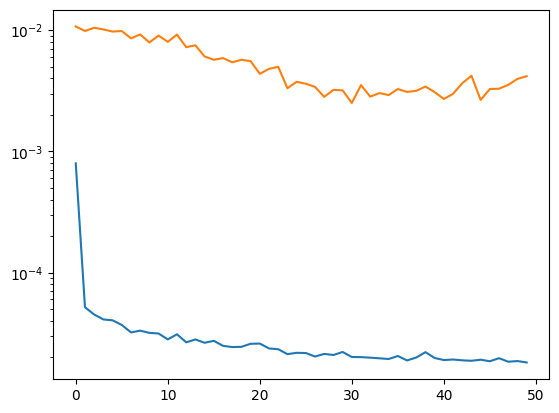

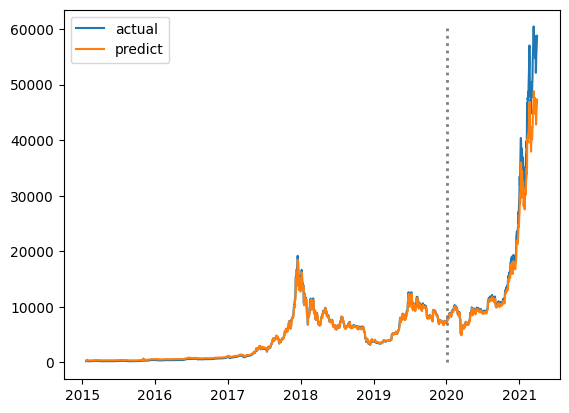

In [8]:
df = load_csv()

# Fit scalers to data
scalers = {}
for x in df.columns:
    scalers[x] = MinMaxScaler(feature_range=(0, 1)).fit(df[x].values.reshape(-1, 1))

# Transform features via scalers
norm_df = df.copy()
for i, key in enumerate(scalers.keys()):
    norm = scalers[key].transform(norm_df.iloc[:, i].values.reshape(-1, 1))
    norm_df.iloc[:, i] = norm
df = norm_df

# Set up the target we want to predict
target_sensor = "Close"
features = list(df.columns)
target = f"{target_sensor}_lead{NUM_FORECAST}"

df[target] = df[target_sensor].shift(-NUM_FORECAST)
df = df.iloc[:-NUM_FORECAST]

# Train/test split of 80%
test_frac = 0.8

df_train = df.iloc[: int(len(df) * test_frac)].copy()
df_test = df.iloc[int(len(df) * test_frac) :].copy()

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=SEQ_LENGTH
)
test_dataset = SequenceDataset(
    df_test, target=target, features=features, sequence_length=SEQ_LENGTH
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = LSTM(num_sensors=len(features), hidden_units=NUM_HIDDEN_UNITS)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

train_losses = []
test_losses = []
best_train_loss = 1
best_test_loss = 1

for ix_epoch in range(NUM_EPOCHS):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    best_train_loss = min(best_train_loss, train_loss)
    train_losses.append(train_loss)
    test_loss = test_model(test_loader, model, loss_function)
    best_test_loss = min(best_test_loss, test_loss)
    test_losses.append(test_loss)
    print()

train_eval_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.yscale("log")
plt.show()

for col in df_out.columns:
    df_out[col] = scalers[target_sensor].inverse_transform(df_out[col].values.reshape(-1, 1))

plt.plot(df_out.index, df_out[f"{target_sensor}_lead{NUM_FORECAST}"], label="actual")
plt.plot(df_out.index, df_out[f"{ystar_col}"], label="predict")
plt.vlines(x=df_out.index[int(len(df) * test_frac)], ymin=0, ymax=df_out.max().max(), colors='grey', ls=':', lw=2)
plt.legend()
plt.show()